In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import warnings
warnings.filterwarnings("ignore")
from fastai.text import *
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

In [3]:
tweet = pd.read_csv('Tweets.csv')
tweet.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
tweet.shape

(14640, 15)

In [5]:
df = tweet[['airline_sentiment', 'text']]
df.sample(5)

,airline_sentiment,text
11791,positive,@USAirways thank you! I tried that and they sa...
5987,positive,@SouthwestAir @FortuneMagazine well deserved!
8685,negative,@JetBlue they say they have no update. I don't...
1902,neutral,"@united Out of curiosity, when a flight is arr..."
122,negative,@VirginAmerica I like the customer service but...


In [6]:
df.shape

(14640, 2)

In [7]:
df.isna().sum()

airline_sentiment    0
text                 0
dtype: int64

In [8]:
df['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [9]:
df['text'].value_counts()

@united thanks                                                                                                                                 6
@JetBlue thanks!                                                                                                                               5
@SouthwestAir sent                                                                                                                             5
@AmericanAir thanks                                                                                                                            5
@united thank you!                                                                                                                             4
                                                                                                                                              ..
@AmericanAir why is it most first class passengers now request the sand which from coach ?                                        

negative    0.626913
neutral     0.211680
positive    0.161407
Name: airline_sentiment, dtype: float64


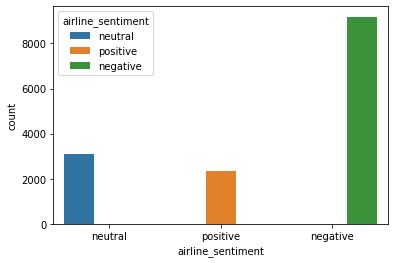

In [10]:
sns.countplot(x=df['airline_sentiment'], hue=df['airline_sentiment'])
print(df['airline_sentiment'].value_counts(normalize=True))

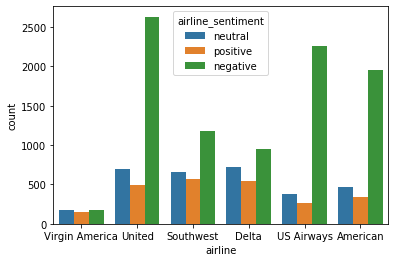

In [11]:
sns.countplot(x='airline', hue='airline_sentiment', data=tweet)

In [12]:
top = 10
Counter("".join(df[df['airline_sentiment']=='positive'].text).split()).most_common(top)

[('the', 924),
 ('to', 923),
 ('for', 658),
 ('I', 570),
 ('a', 501),
 ('you', 486),
 ('and', 416),
 ('on', 327),
 ('my', 320),
 ('in', 307)]

In [13]:
Counter("".join(df[df['airline_sentiment']=='negative'].text).split()).most_common(top)

[('to', 5960),
 ('the', 3928),
 ('I', 3368),
 ('a', 3085),
 ('and', 2685),
 ('for', 2662),
 ('on', 2577),
 ('my', 2225),
 ('you', 2070),
 ('is', 1956)]

In [14]:
Counter("".join(df[df['airline_sentiment']=='neutral'].text).split()).most_common(top)

[('to', 1645),
 ('I', 1103),
 ('the', 927),
 ('a', 770),
 ('on', 630),
 ('you', 610),
 ('for', 597),
 ('my', 490),
 ('in', 443),
 ('and', 443)]

In [15]:
airlines = tweet['airline'].unique()
airlines

array(['Virgin America', 'United', 'Southwest', 'Delta', 'US Airways', 'American'], dtype=object)

In [16]:
pattern = r'@[\w]+'
func = lambda x:re.sub(pattern, '', x)
df['text'] = df['text'].apply(func)
df.sample(5)

,airline_sentiment,text
11207,negative,502 M-phx Im still on The plane waiting And w...
941,positive,that's exactly the point. It fits. I'm premie...
10903,negative,sitting on the ground in Charlotte with no ga...
13357,negative,when do you anticipate decisions for Cancell...
7868,neutral,I would like to receive offers.


In [0]:
train, valid = train_test_split(df, test_size=0.25)
data_lm = TextLMDataBunch.from_df('./', train, valid)
moms = (0.8,0.7)
wd = 0.1

In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-02
Min loss divided by 10: 5.25E-02


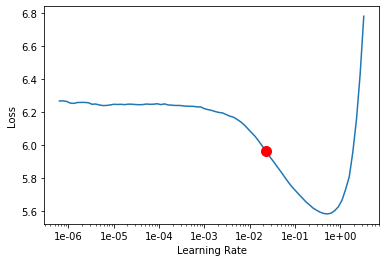

In [19]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [20]:
learn.fit_one_cycle(1, 2.75E-02, moms=moms, wd=wd)

epoch,train_loss,valid_loss,accuracy,time
0,4.483329,3.993841,0.265893,00:05


In [21]:
learn.unfreeze()
learn.fit_one_cycle(5, 2.75E-02, moms=moms, wd=wd)

epoch,train_loss,valid_loss,accuracy,time
0,3.975460,3.993408,0.265938,00:07
1,4.007973,3.954959,0.269576,00:07
2,3.805143,3.981371,0.259230,00:07
3,3.421421,3.809478,0.295312,00:07
4,2.788456,3.914285,0.293058,00:07


In [22]:
learn.predict('It was a decent experience', n_words=10)
            

'It was a decent experience . We apologize for the time , as she'

In [23]:
learn.predict('Service was not that great', n_words=10)

'Service was not that great , UA ! ! xxbos can u help checkin'

In [0]:
learn.save_encoder('encoder.pth')

In [26]:
classifier = TextClasDataBunch.from_df('./', train, valid, test_df=df, vocab=data_lm.train_ds.vocab,
                                          label_cols='airline_sentiment', text_cols='text')
classifier.show_batch()

text,target
xxbos xxmaj hi have a question re future xxmaj flight xxmaj booking xxmaj problems . xxup dub - xxup jac 29 / 9 xxup jac - xxup lax 8 / 10 xxup lax - xxup dub 13 / 10 . i 'm * xxup xxunk xxmaj what is checked bag allowance for xxup jac - xxup lax ?,neutral
xxbos xxmaj the xxmaj fact xxmaj that u xxmaj see xxmaj black xxmaj history xxmaj month 12 xxmaj months a xxmaj year xxmaj is xxmaj xxunk ! xxmaj we xxup will xxup be xxmaj an xxmaj xxunk xxmaj base xxmaj for xxmaj corp. xxmaj like u xxmaj in xxmaj future !,positive
"xxbos e xxrep 4 y ! xxmaj cancelled xxmaj flightlations , xxmaj flight xxmaj booking xxmaj problemss , reflight xxmaj booking xxmaj problemss , but y' all got me on the same flight out tonight ( not tomorrow ) & & the xxup fc upgrade . xxmaj thx !",positive
"xxbos . ( 2 / 3 ) ... i sat on the runway for 4 xxup more xxup hrs b4 takeoff ( 10 hrs xxmaj late xxmaj flight , xxunk xxup am ) . xxmaj pilot xxunk stated it was a comp / mech issue .",negative
"xxbos xxmaj waiting for 3494 xxup ewr - xxup ord , delayed 47 mins . xxmaj might miss xxunk xxup ord - xxup ywg at 6 pm xxup ct . xxmaj any room on xxunk xxup ord - xxup ywg in case i miss xxunk ?",negative


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.00E-03
Min loss divided by 10: 4.37E-02


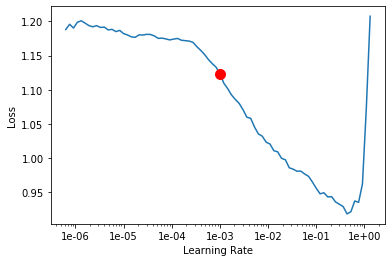

In [27]:
learn = text_classifier_learner(classifier, AWD_LSTM, drop_mult=0.3)
learn.load_encoder('encoder.pth')
learn.freeze()

learn.lr_find()
learn.recorder.plot(suggestion=True)

In [28]:
learn.fit_one_cycle(1, 3.02E-03, moms=moms, wd=wd)

epoch,train_loss,valid_loss,accuracy,time
0,0.619962,0.512314,0.796721,00:04


In [29]:
learn.freeze_to(-2)
lr = 3.63E-03 / 5
learn.fit_one_cycle(1, slice(lr/2**4, lr), moms=moms, wd=wd)

epoch,train_loss,valid_loss,accuracy,time
0,0.562730,0.509021,0.796721,00:04


In [30]:
learn.freeze_to(-3)
lr /= 2
learn.fit_one_cycle(1, slice(lr/(2.6**4), lr), moms=moms, wd=wd)

epoch,train_loss,valid_loss,accuracy,time
0,0.498715,0.514062,0.799727,00:07


In [31]:
learn.unfreeze()
lr /= 5
learn.fit_one_cycle(10, slice(lr/(2.6**4), lr), moms=moms, wd=wd)

epoch,train_loss,valid_loss,accuracy,time
0,0.493143,0.494813,0.800546,00:09
1,0.500569,0.492695,0.801639,00:08
2,0.489724,0.493729,0.800546,00:09
3,0.481849,0.487229,0.800820,00:09
4,0.473609,0.486628,0.802459,00:08
5,0.467097,0.484993,0.802186,00:09
6,0.458309,0.488083,0.804918,00:08
7,0.456501,0.485149,0.803005,00:08
8,0.450561,0.484187,0.804098,00:09
9,0.453674,0.486252,0.804098,00:09


In [32]:
learn.fit_one_cycle(5, slice(lr/(2.6**4), lr), moms=moms, wd=wd)

epoch,train_loss,valid_loss,accuracy,time
0,0.449373,0.487534,0.805191,00:09
1,0.428325,0.483301,0.807650,00:09
2,0.444370,0.478748,0.806011,00:09
3,0.433857,0.479315,0.809290,00:09
4,0.446719,0.480692,0.811749,00:09


In [33]:
learn.predict('Great flight')

(Category positive, tensor(2), tensor([9.6412e-04, 2.0311e-02, 9.7873e-01]))

In [34]:
learn.predict('staff behaviour was good')

(Category positive, tensor(2), tensor([0.2470, 0.3669, 0.3861]))

In [35]:
learn.predict('service was good but flight got delayed')

(Category negative, tensor(0), tensor([0.5263, 0.0392, 0.4345]))

In [39]:
learn.predict('why is it most first class passengers now request the sand which from coach ?')

(Category negative, tensor(0), tensor([0.4952, 0.4777, 0.0271]))

In [36]:
interp = TextClassificationInterpretation.from_learner(learn)
acc = accuracy(interp.preds, interp.y_true)
print('Accuracy: {0:.3f}'.format(acc))

Accuracy: 0.812


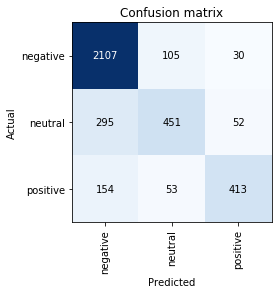

In [37]:
interp.plot_confusion_matrix()

In [0]:

learn.save('model.pth')